# T81-558: Applications of Deep Neural Networks
**Final Project: Tathagata Banerjee**



## Problem and DataSet

  For the final project I want to do an independent assignment. The dataset that I am using is the Glass Identification Data Set from the University of California Irvine, Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Glass+Identification. For this particular project I use the formatted dataset in Dr. Heaton's Github page.
  
  The purpose of this problem is to classify the type of glass based on the chemical composition. There are nine attributes(excluding the id) and each of these represents the weight percentage in the corresponding oxide. We want to perform **Classification** based on these attributes. There are seven possible classes of the glass that we are trying to classify into. The field we are interested in for prediction is **'type'**.
  
  For this particular dataset, there is **No Missing Data**.
  
 
## Pre-Processing Step

First I dropped the 'id' column and then shuffled the rows.

Since all the attributes are **numeric and continuous** ,I encoded all the attribute columns as **z-scores**. 


## Creating a Neural Network Model

I used 5-Fold Cross-Validation for this project. For the system architecture I had two hidden layers with 50 and 25 neurons simultaneously.For the hidden layers the activation function was 'relu'. For the output layer the activation was 'softmax', since this is a Classification problem.

## Evaluation Metric

For evaluating the performance, we use **Classification Accuracy** as our metric.

$ accuracy = \frac{\textit{#} \ correct}{N} $
Where $N$ is the size of the evaluted set (training or validation).

I calculate the **Percentage Accuracy** for this model and we get 100% accuracy.

## Graphic Evaluation

I use **Confusion Matrix** for Graphic Evaluation.

## Final Comments

I performed Classification using a neural network. I tried to classify the Type of Glass depending on the Chemical composition. I managed to achieve extremely good accuracy.

This dataset was straightforward and easy to work with. The only confusion I had is deciding on the optimal value of hyperparameters(which I tried manually).




In [3]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        

## Pre-Processing Step

First I dropped the 'id' column and then shuffled the rows.

Since all the attributes are **numeric and continuous** ,I encoded all the attribute columns as **z-scores**. 

In [4]:
import os
import pandas as pd
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

path ="/Users/tbanerjee/Documents/courses/DeepLearning/DLUPDATED/t81_558_deep_learning-master/data/"
filename_read = os.path.join(path,"glass.csv")
df = pd.read_csv(filename_read)

#Shuffling the dataset 

np.random.seed(42) 
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode the feature vector

df.drop('id',1,inplace=True)
species = encode_text_index(df,"type")

encode_numeric_zscore(df, 'ri', mean=None, sd=None)
encode_numeric_zscore(df, 'na', mean=None, sd=None)
encode_numeric_zscore(df, 'mg', mean=None, sd=None)
encode_numeric_zscore(df, 'al', mean=None, sd=None)
encode_numeric_zscore(df, 'si', mean=None, sd=None)
encode_numeric_zscore(df, 'k', mean=None, sd=None)
encode_numeric_zscore(df, 'ca', mean=None, sd=None)
encode_numeric_zscore(df, 'ba', mean=None, sd=None)
encode_numeric_zscore(df, 'fe', mean=None, sd=None)

x,y = to_xy(df,"type")

Using TensorFlow backend.
/Users/tbanerjee/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Creating a Neural Network Model

I used 5-Fold Cross-Validation for this project. For the system architecture I had two hidden layers with 50 and 25 neurons simultaneously.For the hidden layers the activation function was 'relu'. For the output layer the activation was 'softmax', since this is a Classification problem.

In [5]:
# Cross-Validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')

    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    
    pred = model.predict(x_test)
    
    y_test=np.argmax(y_test,axis=1)
    oos_y.append(y_test)
    
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred) 
    
# Build the oos prediction list 

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)


# Create the cross-validated prediction


df['Actual Class']=oos_y
df['Predicted Class']=oos_pred

oosDF=df[['Actual Class','Predicted Class']].copy()

# Save a copy 
oosDF.to_csv('Project.csv',index=False)

Fold #1
Epoch 00711: early stopping
Fold #2
Epoch 00986: early stopping
Fold #3
Epoch 00890: early stopping
Fold #4
Epoch 00813: early stopping
Fold #5
Epoch 00707: early stopping


## Evaluation Metric

For evaluating the performance, we use **Classification Accuracy** as our metric.

$ accuracy = \frac{\textit{#} \ correct}{N} $
Where $N$ is the size of the evaluted set (training or validation).

I calculate the **Percentage Accuracy**.

In [6]:
score = metrics.accuracy_score(oos_y, oos_pred)
print("Final score (accuracy): {}".format(score))

Final score (accuracy): 1.0


## Graphic Evaluation

I use **Confusion Matrix** for Graphic Evaluation.

Confusion matrix, without normalization
[[70  0  0  0  0  0]
 [ 0 76  0  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 29]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


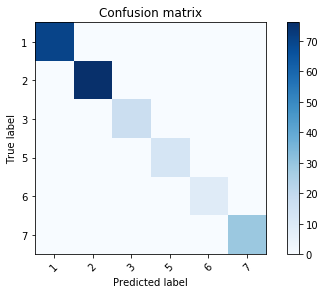

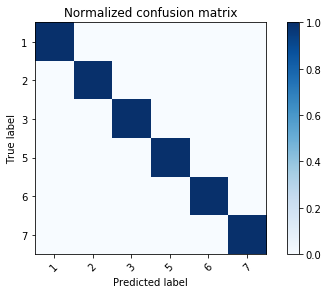

In [7]:
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(oos_y, oos_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, species)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, species, title='Normalized confusion matrix')

plt.show()

## Final Comments

I performed Classification using a neural network. I tried to classify the Type of Glass depending on the Chemical composition. I managed to achieve extremely good accuracy.

This dataset was straightforward and easy to work with. The only confusion I had is deciding on the optimal value of hyperparameters(which I tried manually).